# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



# IMPORTANT: Make sure the temperature (set below) matches the temperature you used to run the simulations.

In [1]:
%cd ..
%pwd

/u2/home_u2/ems363/Documents/safep


'/u2/home_u2/ems363/Documents/safep'

In [2]:
import warnings
import logging
import copy
from AFEP_parse import *
import matplotlib as mpl
plt.rcParams['figure.dpi'] = 150

logging.captureWarnings(True)
#warnings.simplefilter(action='ignore', category=FutureWarning)
logger = logging.getLogger("alchemlyb.parsers.NAMD")
logging.disable(level='CRITICAL')

from helpers import *

In [3]:
## Membranes
root = '/home/ems363/Documents/ELIC_DCDs_Analyses/'
#root = '/home/ezry/winHome/Documents/ELIC_Data/ELIC/'
systems = ['PCPGPE211', 'PCPG31', 'POPC120']
longSysNames = {'PCPGPE211':r'$\rm2_{POPC}:1_{POPE}:1_{POPG}$', 'PCPG31':r'$\rm3_{POPC}:1_{POPG}$', 'POPC120':'POPC'}

prefixes = ['POCE', 'POCG', 'POEG', 'POGE']
longNames = {'POCE':'POPC to POPE', 'POCG':'POPC to POPG', 'POEG':'POPE to POPG', 'POGE':'POPG to POPE'}

lambdas = np.round(np.linspace(0,1,41),5)

pattern = 'PO*fepout'
checkReplicas = True

In [4]:
temperature = 303.15
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

In [5]:
allSys = {}

for sys in systems:
    path = root+sys+'/'
    try:
        system = loadSystem(path)
        print(f"Read {sys} from {path}")
    except:
        system = processAllLegs(path, prefixes, pattern, lambdas, temperature, RT, decorrelate, detectEQ)
        saveSystem(system, path)
    allSys[sys] = system

['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_111/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_32/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_69/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_84/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_9/']
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_111/
Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_32/
Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_69/
Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_84/
Decorrelating samples. Flag='True'
Reading /home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCE_9/
Decorrelating samples. Flag='True'
['/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_115/', '/home/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POCG_22/', '/home/ems363/Documents/ELIC_

In [7]:
test_system=copy.deepcopy(allSys['PCPGPE211'])

In [30]:
def cumulativePlot(system, leg, theax):
    cumulative = system['cumulatives'][leg]
    keyColors = system['keyColors'][leg]
    X = cumulative.index
    df_cumulative = cumulative.loc(axis=1)[(slice(None), 'f')]*RT
    df_cumulative.plot(ax=theax, marker=None, legend=None, linewidth=1, color=keyColors)
    
    finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
    theax.axhline(finalMean*RT, color='gray', linestyle='-.', linewidth=1)
    print(f"{leg} mean: {finalMean*RT}")
    return theax


def convergencePlot(system, leg, theax):
    keyColors = dict(system['keyColors'][leg])
    kwargs = {'legend':None, 'marker':'o', 'linewidth':1, 'color':keyColors, 'markerfacecolor':'white', 'markeredgewidth':1, 'ms':5}
    convergence = np.multiply(system['convergence'][leg], RT)
    length = len(convergence)
    fX = (np.arange(length)+1)/length
    bX = (np.arange(length)+1)/length
    
    convergence.index = convergence.index/length+1/length
    
    df_forward = convergence.loc(axis=1)[(slice(None), 'forward')].droplevel(1, axis=1)
    df_backward = convergence.loc(axis=1)[(slice(None), 'backward')].droplevel(1, axis=1)
    df_forward.plot(ax = theax, **kwargs)
    df_backward.plot(ax = theax, linestyle='--', **kwargs)
    
    theax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    cumulative = system['cumulatives'][leg]
    finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
    theax.axhline(y= finalMean*RT, linestyle='-.', color='gray')
    print(f"{leg} mean: {finalMean*RT}")
    theax.plot(0, finalMean*RT, linewidth=1, color='black', label='Forward Time Sampling')
    theax.plot(0, finalMean*RT, linewidth=1, color='black', linestyle='--', label='Backward Time Sampling')
    
    return theax


def hysteresisPlot(system, leg, theax):
    perWindow = system['perWins'][leg].loc(axis=1)[(slice(None), 'diff')].droplevel(1,axis=1)
    keyColors = dict(system['keyColors'][leg])
    df_hyster = np.multiply(perWindow,RT)
    
    # Hysteresis plot
    df_hyster.drop('mean', axis=1).plot(ax=theax, linewidth=0.5, alpha=0.8, color=keyColors, legend=None)

    theax.plot(perWindow.index, perWindow['mean']*RT, linewidth=1.5, color='black')
    theax.set(ylim=(-1.25, 1.25))

    return theax

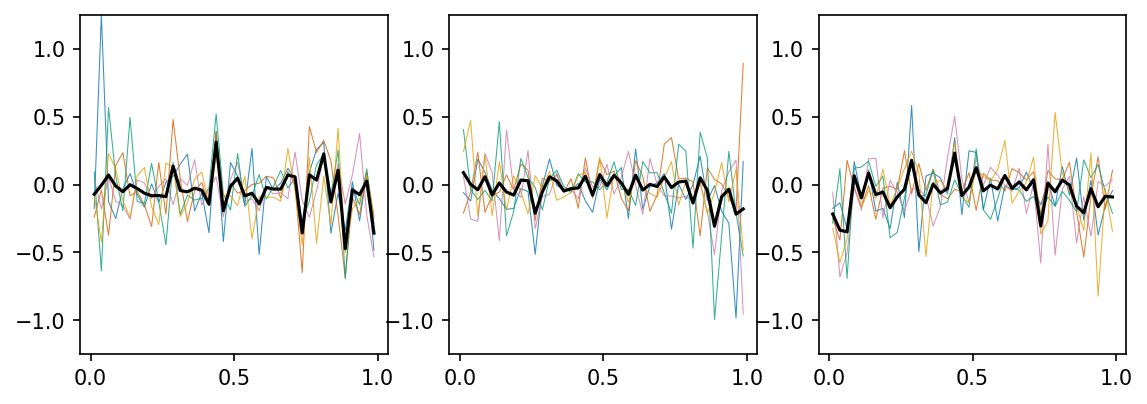

In [31]:
fig, (cg, ce, eg) = plt.subplots(1,3, figsize=(9,3))
testPlot = hysteresisPlot
cg = testPlot(test_system, 'POCG', cg)
ce = testPlot(test_system, 'POCE', ce)
eg = testPlot(test_system, 'POEG', eg)

In [ ]:
   
def hysteresisPDF(system, leg, keys, keyColors, theax):
    
    perWindow = system['perWins'][leg]
    # Hysteresis PDF
    diff = perWindow.loc[:, (slice(None), 'diff')]*RT
    X = diff.drop(columns='mean') #Including the mean in here would underestimate the skewness of the distribution
    Y = np.arange(len(X))/len(X)
    binNum = 20
    pdfY, pdfX = np.histogram(X, bins=binNum, density=True)
    pdfX = (pdfX[1:]+pdfX[:-1])/2


    #plot the data
    theax.plot(pdfX, pdfY,  label="Estimated Distribution")
    theax.set(xlim=(-1.25, 1.25))
    
    return theax


def makePlots(allSys, systems, prefixes, xlabel, ylabel, doPlot, sharey=True, sharex=True):
    fig, theaxes = plt.subplots(3,len(systems), sharex=sharex, sharey=sharey)
    pad = 5 # in points
    
    for sysID in np.arange(len(systems)):
        sysName = systems[sysID]
        system = allSys[sysName]
        print(f'Now making figures for: {sysName}')
        theaxes[2, sysID].set(xlabel=xlabel)
        theaxes[0, sysID].annotate(longSysNames[sysName], xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        for prefID in np.arange(len(prefixes)):
            # Cumulative change in kT 
            leg = prefixes[prefID]
            try:
                keys = system['keyColors'][leg]
                keyColors = system['keyColors'][leg]
                theaxes[prefID, 0].set(ylabel=ylabel)
                theaxes[prefID, 0].annotate(longNames[leg], xy=(0, 0.5), xytext=(-theaxes[prefID, 0].yaxis.labelpad - pad, 0),
                        xycoords=theaxes[prefID, 0].yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)

                theax = doPlot(system, leg, keys, keyColors, theaxes[prefID, sysID])
            except:
                continue
            
    fig.set_figheight(10)
    fig.set_figwidth(8)
    fig.tight_layout()
    
    return fig, theaxes


In [ ]:
# #Uniquely necessary for PCPG3:1 membrane system

# for dat in allSys['PCPG31'].keys():
#     allSys['PCPG31'][dat]['POEG'] = copy.deepcopy(allSys['PCPG31'][dat]['POGE'])
    
    
# for x in allSys['PCPG31']['fs']['POGE'].keys():
#     allSys['PCPG31']['fs']['POEG'][x] = np.multiply(copy.deepcopy(allSys['PCPG31']['fs']['POGE'][x]), -1)
    
# for x in allSys['PCPG31']['bs']['POGE'].keys():
#     allSys['PCPG31']['bs']['POEG'][x] = np.multiply(copy.deepcopy(allSys['PCPG31']['bs']['POGE'][x]), -1)
    
# for x in allSys['PCPG31']['cumulatives']['POGE'].keys():
#     allSys['PCPG31']['cumulatives']['POEG'][x] = np.multiply(copy.deepcopy(allSys['PCPG31']['cumulatives']['POGE'][x]), -1)
for x in allSys['PCPG31']['cumulatives']['POEG'].keys():
    baseline = allSys['PCPG31']['cumulatives']['POGE'][x].iloc[-1]*-1
    allSys['PCPG31']['cumulatives']['POEG'][x] = (copy.deepcopy(allSys['PCPG31']['cumulatives']['POGE'][x]) + baseline)
    temp = np.flip(allSys['PCPG31']['cumulatives']['POEG'][x])
    temp.index = allSys['PCPG31']['cumulatives']['POEG'][x].index
    
    allSys['PCPG31']['cumulatives']['POEG'][x] = copy.deepcopy(temp)
    
allSys['PCPGPE211']['keyColors']['POEG']['POEG_Good'] = '#000000'

In [ ]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel='Fraction of simulation time', ylabel=r'$\rm\Delta G (kcal/mol)$', doPlot=convergencePlot, sharey='row')
plt.savefig(f"{root}/DRAFT_S1.pdf")

In [ ]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=r'$\rm\delta_{\lambda}$ (kcal/mol)', doPlot=hysteresisPlot, sharey='row')
plt.savefig(f"{root}/DRAFT_S2.pdf")

In [ ]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\delta_{\lambda}$ (kcal/mol)', ylabel='PDF', doPlot=hysteresisPDF, sharey=True)
plt.savefig(f"{root}/DRAFT_S3.pdf")

In [ ]:
fig, dGaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=fr'Cumulative $\rm\Delta$G($\rm\lambda$) (kcal/mol)', doPlot=cumulativePlot)
plt.savefig(f"{root}/DRAFT_S4.pdf")